# Netzwerkanalyse

Dieses Notebook führt eine umfassende Analyse des Modulnetzwerks durch.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import community as community_louvain
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import combinations, chain
import warnings
warnings.filterwarnings('ignore')

# Setze Style für bessere Visualisierungen
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


## 1. Datenladen und Netzwerkaufbau


In [2]:
# Daten laden
edges = pd.read_csv('../data/edges.csv')
nodes = pd.read_csv('../data/nodes.csv')

# Netzwerk aufbauen
G = nx.from_pandas_edgelist(edges, 'Source', 'Target', 
                           edge_attr='Label', create_using=nx.DiGraph())

# Knotenattribute hinzufügen
nx.set_node_attributes(G, nodes.set_index('Id')['Gruppe'].to_dict(), 'Gruppe')
nx.set_node_attributes(G, nodes.set_index('Id')['Semester'].to_dict(), 'Semester')
nx.set_node_attributes(G, nodes.set_index('Id')['Name'].to_dict(), 'Name')

# Ungerichtete Version für bestimmte Analysen
G_undir = G.to_undirected()

print(f"Netzwerk: {G.number_of_nodes()} Knoten, {G.number_of_edges()} Kanten")
print(f"Gerichtet: {nx.is_directed(G)}")
print(f"Zyklisch: {not nx.is_directed_acyclic_graph(G)}")


Netzwerk: 14 Knoten, 12 Kanten
Gerichtet: True
Zyklisch: False


## 2. Grundlegende Netzwerkmetriken


In [3]:
print("=== Grundlegende Netzwerkmetriken ===")
print(f"Dichte: {nx.density(G):.4f}")
print(f"Durchschnittlicher Grad: {2*G.number_of_edges()/G.number_of_nodes():.2f}")

# Connected Components
scc = list(nx.strongly_connected_components(G))
wcc = list(nx.weakly_connected_components(G))
print(f"Strongly Connected Components: {len(scc)}")
print(f"Weakly Connected Components: {len(wcc)}")

if len(scc) > 0:
    largest_scc = max(scc, key=len)
    G_scc = G.subgraph(largest_scc).copy()
    if len(largest_scc) > 1:
        print(f"Diameter größter SCC: {nx.diameter(G_scc)}")
        print(f"Radius größter SCC: {nx.radius(G_scc)}")
    else:
        print("Größter SCC hat nur 1 Knoten")

# Clustering
print(f"Average Clustering (ungerichtet): {nx.average_clustering(G_undir):.4f}")

# Transitivität
print(f"Transitivität: {nx.transitivity(G_undir):.4f}")


=== Grundlegende Netzwerkmetriken ===
Dichte: 0.0659
Durchschnittlicher Grad: 1.71
Strongly Connected Components: 14
Weakly Connected Components: 2
Größter SCC hat nur 1 Knoten
Average Clustering (ungerichtet): 0.0000
Transitivität: 0.0000


### Interpretation der grundlegenden Netzwerkmetriken

**Dichte (0.0659):** Das Netzwerk ist sehr spärlich - nur 6.6% der möglichen Verbindungen existieren. Dies ist typisch für Voraussetzungsnetzwerke, da nicht jedes Modul Voraussetzung für jedes andere sein kann. Die niedrige Dichte zeigt eine klare, hierarchische Struktur des Studienplans.

**Durchschnittlicher Grad (1.71):** Im Durchschnitt hat jedes Modul weniger als 2 Verbindungen. Dies bestätigt, dass die Voraussetzungen gezielt und nicht übermäßig komplex sind.

**Connected Components:** 
- **14 Strongly Connected Components:** Jedes Modul ist in seiner eigenen starken Komponente, was bedeutet, dass es keine Rückkopplungen gibt (kein Modul ist Voraussetzung für ein anderes, das wiederum Voraussetzung für das erste ist). Dies ist ideal für einen Studienplan.
- **2 Weakly Connected Components:** Es gibt zwei getrennte Bereiche im Netzwerk. Die Hauptkomponente enthält die Projektsequenz (pro1M → pro6M), während die zweite Komponente nur aus `bb → wch` besteht. Dies deutet darauf hin, dass `bb` und `wch` isoliert vom Rest des Curriculums sind.

**Clustering & Transitivität (0.0000):** Beide Werte sind null, was bedeutet, dass es keine Dreiecke im Netzwerk gibt. Dies ist charakteristisch für DAGs (Directed Acyclic Graphs) und zeigt, dass die Voraussetzungen linear und nicht zyklisch strukturiert sind.


## 3. Zentralitätsmasse (verschiedene Perspektiven)


In [ ]:
print("=== Zentralitätsmasse ===")

# Verschiedene Zentralitätsmasse berechnen
centralities = {
    'InDegree': nx.in_degree_centrality(G),
    'OutDegree': nx.out_degree_centrality(G),
    'Closeness': nx.closeness_centrality(G),
    'Betweenness': nx.betweenness_centrality(G),
    'Eigenvector': nx.eigenvector_centrality(G, max_iter=1000),
    'PageRank': nx.pagerank(G),
    'Katz': nx.katz_centrality(G, max_iter=1000)
}

cent_df = pd.DataFrame(centralities).round(4)

print("\nTop 5 nach Betweenness (Brückenmodule):")
print(cent_df.sort_values('Betweenness', ascending=False).head())

print("\nTop 5 nach InDegree (beliebte Voraussetzungen):")
print(cent_df.sort_values('InDegree', ascending=False).head())

print("\nTop 5 nach OutDegree (Module mit vielen Voraussetzungen):")
print(cent_df.sort_values('OutDegree', ascending=False).head())


=== Zentralitätsmaße ===

Top 5 nach Betweenness (Brückenmodule):
       InDegree  OutDegree  Closeness  Betweenness  Eigenvector  PageRank  \
pro4M    0.3077     0.0769     0.4154       0.1154       0.0001    0.1976   
pro3M    0.3077     0.0769     0.3205       0.0962       0.0000    0.1280   
pro5M    0.0769     0.0769     0.3077       0.0641       0.0083    0.1929   
pro2M    0.0769     0.0769     0.0769       0.0256       0.0000    0.0462   
bb       0.0000     0.0769     0.0000       0.0000       0.0000    0.0250   

         Katz  
pro4M  0.3491  
pro3M  0.3416  
pro5M  0.2772  
pro2M  0.2665  
bb     0.2423  

Top 5 nach InDegree (beliebte Voraussetzungen):
       InDegree  OutDegree  Closeness  Betweenness  Eigenvector  PageRank  \
pro3M    0.3077     0.0769     0.3205       0.0962       0.0000    0.1280   
pro4M    0.3077     0.0769     0.4154       0.1154       0.0001    0.1976   
wch      0.0769     0.0000     0.0769       0.0000       0.0000    0.0462   
pro2M    0.0769   

### Interpretation der Zentralitätsmaße

**Betweenness Centrality - Brückenmodule:**
- **pro4M** (0.1154) und **pro3M** (0.0962) haben die höchste Betweenness-Zentralität. Diese Module sind kritische "Engpässe" im Studienplan - viele Pfade führen durch sie hindurch. Wenn ein Student diese Module nicht besteht, blockiert dies den Fortschritt zu vielen nachfolgenden Modulen.
- **Praktische Implikation:** Diese Module sollten besonders unterstützt werden (z.B. durch zusätzliche Tutorien oder flexible Prüfungstermine), da sie den Studienfortschritt maßgeblich beeinflussen.

**In-Degree Centrality - Beliebte Voraussetzungen:**
- **pro3M** und **pro4M** (je 0.3077) haben die meisten eingehenden Verbindungen. Dies bedeutet, dass viele Module diese als Voraussetzung haben.
- **Interpretation:** Diese Module sind fundamentale Bausteine, auf denen viele weitere Module aufbauen. Studenten sollten diese Module frühzeitig und erfolgreich abschließen.

**Out-Degree Centrality - Module mit vielen Voraussetzungen:**
- **bb, pro1M, stk, pro2M, pro3M** (je 0.0769) haben ausgehende Verbindungen. Dies zeigt Module, die Voraussetzungen für andere sind.
- **Besonders interessant:** `bb` hat nur eine ausgehende Verbindung (zu `wch`), ist aber isoliert vom Hauptnetzwerk. Dies könnte auf eine fehlende Verbindung im Studienplan hinweisen.

**PageRank & Katz Centrality:**
- **pro4M** hat den höchsten PageRank (0.1976), gefolgt von **pro5M** (0.1929). Diese Module sind nicht nur zentral, sondern auch mit anderen zentralen Modulen verbunden.
- **Bedeutung:** Diese Module sind strategisch wichtig - sie verbinden verschiedene Bereiche des Curriculums.


## 4. Pfadanalyse - Kritische Wege im Netzwerk


In [5]:
print("=== Pfadanalyse ===")

# Finde alle kürzesten Pfade zwischen Knoten
all_pairs_shortest_paths = dict(nx.all_pairs_shortest_path_length(G))

# Finde längste Pfade (kritische Pfade)
def find_longest_paths(G):
    """Finde die längsten Pfade im DAG"""
    longest_paths = []
    max_length = 0
    
    # Finde Quellen (Knoten ohne eingehende Kanten)
    sources = [n for n in G.nodes() if G.in_degree(n) == 0]
    # Finde Senken (Knoten ohne ausgehende Kanten)
    sinks = [n for n in G.nodes() if G.out_degree(n) == 0]
    
    for source in sources:
        for sink in sinks:
            if nx.has_path(G, source, sink):
                path = nx.shortest_path(G, source, sink)
                length = len(path) - 1
                if length > max_length:
                    max_length = length
                    longest_paths = [path]
                elif length == max_length:
                    longest_paths.append(path)
    
    return longest_paths, max_length

longest_paths, max_path_length = find_longest_paths(G)
print(f"Längster Pfad: {max_path_length} Schritte")
print(f"Anzahl längster Pfade: {len(longest_paths)}")
if longest_paths:
    print(f"Beispiel längster Pfad: {' -> '.join(longest_paths[0])}")

# Durchschnittliche Pfadlänge
path_lengths = []
for source in G.nodes():
    for target in G.nodes():
        if source != target and nx.has_path(G, source, target):
            path_lengths.append(nx.shortest_path_length(G, source, target))

if path_lengths:
    print(f"Durchschnittliche Pfadlänge: {np.mean(path_lengths):.2f}")
    print(f"Maximale Pfadlänge: {max(path_lengths)}")


=== Pfadanalyse ===
Längster Pfad: 5 Schritte
Anzahl längster Pfade: 1
Beispiel längster Pfad: pro1M -> pro2M -> pro3M -> pro4M -> pro5M -> pro6M
Durchschnittliche Pfadlänge: 2.27
Maximale Pfadlänge: 5


### Interpretation der Pfadanalyse

**Längster Pfad (5 Schritte):** Der Pfad `pro1M → pro2M → pro3M → pro4M → pro5M → pro6M` ist der kritischste Weg durch das Curriculum. Dies ist die **Projektsequenz**, die über 6 Semester führt.

**Bedeutung für die Studienplanung:**
- Studenten müssen diese Sequenz in der richtigen Reihenfolge durchlaufen
- Ein Ausfall in einem Projektmodul verzögert alle nachfolgenden Projekte
- Dies ist der **kritische Pfad** des Studiums - die minimale Zeit bis zur Bachelor Thesis

**Durchschnittliche Pfadlänge (2.27):** Im Durchschnitt sind Module 2-3 Schritte voneinander entfernt. Dies zeigt eine moderate Vernetzung - Module sind weder zu isoliert noch zu stark verflochten.

**Praktische Empfehlung:**
- Die Projektsequenz sollte besonders unterstützt werden
- Flexible Prüfungstermine für Projektmodule könnten helfen, Verzögerungen zu minimieren
- Frühwarnsysteme für Studenten, die in der Projektsequenz Probleme haben


## 5. Hierarchieanalyse - DAG-Struktur und Ebenen


In [6]:
print("=== Hierarchieanalyse ===")

# Prüfe ob DAG
is_dag = nx.is_directed_acyclic_graph(G)
print(f"Ist DAG: {is_dag}")

if is_dag:
    # Topologische Sortierung
    topo_order = list(nx.topological_sort(G))
    print(f"\nTopologische Sortierung (erste 10): {topo_order[:10]}")
    
    # Ebenen im DAG (wie viele Schritte von der Quelle entfernt)
    def calculate_levels(G):
        levels = {}
        # Quellen sind Level 0
        for node in G.nodes():
            if G.in_degree(node) == 0:
                levels[node] = 0
        
        # BFS um Level zu berechnen
        queue = [n for n in G.nodes() if G.in_degree(n) == 0]
        while queue:
            node = queue.pop(0)
            for neighbor in G.successors(node):
                if neighbor not in levels:
                    levels[neighbor] = levels[node] + 1
                    queue.append(neighbor)
                else:
                    levels[neighbor] = max(levels[neighbor], levels[node] + 1)
        
        return levels
    
    levels = calculate_levels(G)
    level_df = pd.DataFrame(list(levels.items()), columns=['Modul', 'Level'])
    print(f"\nEbenenverteilung:")
    print(level_df['Level'].value_counts().sort_index())
    
    # Module pro Ebene
    print(f"\nModule pro Ebene:")
    for level in sorted(set(levels.values())):
        modules = [m for m, l in levels.items() if l == level]
        print(f"  Ebene {level}: {modules}")
else:
    # Finde Zyklen
    cycles = list(nx.simple_cycles(G))
    print(f"\nAnzahl Zyklen: {len(cycles)}")
    if cycles:
        print(f"Beispiel Zyklen (erste 3):")
        for i, cycle in enumerate(cycles[:3]):
            print(f"  Zyklus {i+1}: {' -> '.join(cycle)} -> {cycle[0]}")


=== Hierarchieanalyse ===
Ist DAG: True

Topologische Sortierung (erste 10): ['bb', 'pro1M', 'stk', 'elstk', 'kmk', 'ten1', 'fems', 'cfds', 'wch', 'pro2M']

Ebenenverteilung:
Level
0    8
1    2
2    1
3    1
4    1
5    1
Name: count, dtype: int64

Module pro Ebene:
  Ebene 0: ['bb', 'pro1M', 'stk', 'elstk', 'kmk', 'ten1', 'fems', 'cfds']
  Ebene 1: ['wch', 'pro2M']
  Ebene 2: ['pro3M']
  Ebene 3: ['pro4M']
  Ebene 4: ['pro5M']
  Ebene 5: ['pro6M']


### Interpretation der Hierarchieanalyse

**DAG-Struktur:** Das Netzwerk ist ein Directed Acyclic Graph - es gibt keine Zyklen. Dies ist **essentiell** für einen Studienplan, da Zyklen bedeuten würden, dass Module gegenseitig Voraussetzungen voneinander sind (unmöglich).

**Ebenenverteilung:**
- **Ebene 0 (8 Module):** Dies sind die "Quellen" - Module ohne Voraussetzungen. Studenten können diese sofort belegen.
- **Ebene 1-5:** Die Projektsequenz bildet eine klare Hierarchie über 5 Ebenen.

**Topologische Sortierung:** Die Sortierung zeigt eine mögliche Belegungsreihenfolge. Interessant ist, dass `wch` (Workshop Chemie) auf Ebene 1 kommt, obwohl es nur von `bb` abhängt - dies bestätigt die isolierte Struktur.

**Praktische Implikationen:**
- **8 Module auf Ebene 0** bieten Studenten Flexibilität in der Belegung
- Die klare Hierarchie erleichtert die Studienplanung
- Die Projektsequenz (pro1M bis pro6M) ist linear und sequenziell - keine Parallelisierung möglich
- **Empfehlung:** Module der gleichen Ebene können parallel belegt werden, was die Studienplanung flexibler macht


## 6. Erreichbarkeitsanalyse - Wer kann wen erreichen?


In [7]:
print("=== Erreichbarkeitsanalyse ===")

# Erreichbarkeitsmatrix
reachability_matrix = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
reachability = nx.transitive_closure(G)

# Anzahl erreichbarer Knoten von jedem Knoten
reachable_counts = {}
for node in G.nodes():
    reachable = set()
    for target in G.nodes():
        if nx.has_path(G, node, target):
            reachable.add(target)
    reachable_counts[node] = len(reachable) - 1  # -1 für sich selbst

reachable_df = pd.DataFrame(list(reachable_counts.items()), 
                           columns=['Modul', 'Erreichbare_Module'])
reachable_df = reachable_df.sort_values('Erreichbare_Module', ascending=False)

print("Top 5 Module mit meisten erreichbaren Modulen:")
print(reachable_df.head())

# Module, die von vielen anderen erreicht werden können
reachable_from_counts = {}
for node in G.nodes():
    count = sum(1 for source in G.nodes() 
                if source != node and nx.has_path(G, source, node))
    reachable_from_counts[node] = count

reachable_from_df = pd.DataFrame(list(reachable_from_counts.items()),
                                columns=['Modul', 'Erreichbar_von'])
reachable_from_df = reachable_from_df.sort_values('Erreichbar_von', ascending=False)

print("\nTop 5 Module, die von den meisten anderen Modulen erreicht werden:")
print(reachable_from_df.head())


=== Erreichbarkeitsanalyse ===
Top 5 Module mit meisten erreichbaren Modulen:
   Modul  Erreichbare_Module
2  pro1M                   5
3  pro2M                   4
5    stk                   4
6  elstk                   4
7    kmk                   4

Top 5 Module, die von den meisten anderen Modulen erreicht werden:
    Modul  Erreichbar_von
13  pro6M              11
12  pro5M              10
8   pro4M               9
4   pro3M               5
1     wch               1


### Interpretation der Erreichbarkeitsanalyse

**Module mit meisten erreichbaren Modulen:**
- **pro1M** kann 5 Module erreichen - es ist der Startpunkt der Projektsequenz
- **pro2M, stk, elstk, kmk** können jeweils 4 Module erreichen

**Module, die von den meisten erreicht werden:**
- **pro6M** (Bachelor Thesis) wird von 11 Modulen erreicht - es ist das Ziel des gesamten Curriculums
- **pro5M** wird von 10 Modulen erreicht
- **pro4M** wird von 9 Modulen erreicht

**Bedeutung:**
- Die Projektsequenz bildet den "Rückgrat" des Curriculums - fast alle Module führen letztendlich zu den Projektmodulen
- **pro6M** (Bachelor Thesis) ist das ultimative Ziel - fast alle Grundlagenmodule sind Voraussetzung dafür
- Dies zeigt, dass die Projektmodule gut in das Curriculum integriert sind

**Praktische Konsequenz:** Studenten, die Probleme mit Grundlagenmodulen haben, werden diese Schwierigkeiten bis zur Bachelor Thesis mit sich tragen. Frühzeitige Unterstützung ist daher besonders wichtig.


## 7. Community Detection - Gruppierung von Modulen


In [8]:
print("=== Community Detection ===")

# Louvain Algorithmus
partition = community_louvain.best_partition(G_undir)
modularity = community_louvain.modularity(partition, G_undir)
print(f"Louvain Modularity: {modularity:.4f}")
print(f"Anzahl Communities: {len(set(partition.values()))}")

# Community-Zuordnung
comm_df = pd.DataFrame(list(partition.items()), columns=['Modul', 'Community'])
comm_df = comm_df.merge(nodes[['Id', 'Gruppe', 'Name']], 
                       left_on='Modul', right_on='Id', how='left')
print("\nCommunities nach Größe:")
print(comm_df.groupby('Community').size().sort_values(ascending=False))

# Zeige Module pro Community
print("\nModule pro Community:")
for comm in sorted(set(partition.values())):
    modules = comm_df[comm_df['Community'] == comm]['Modul'].tolist()
    print(f"  Community {comm}: {modules}")

# Vergleich mit tatsächlichen Gruppen
print("\nCommunity vs. tatsächliche Gruppen:")
comm_group_cross = pd.crosstab(comm_df['Community'], comm_df['Gruppe'])
print(comm_group_cross)


=== Community Detection ===
Louvain Modularity: 0.4896
Anzahl Communities: 5

Communities nach Größe:
Community
0    4
4    4
1    2
2    2
3    2
dtype: int64

Module pro Community:
  Community 0: ['pro4M', 'ten1', 'fems', 'cfds']
  Community 1: ['bb', 'wch']
  Community 2: ['pro5M', 'pro6M']
  Community 3: ['pro1M', 'pro2M']
  Community 4: ['pro3M', 'stk', 'elstk', 'kmk']

Community vs. tatsächliche Gruppen:
Gruppe     Grundlagen:\nNaturwissenschaften  Grundlagen: Labor  \
Community                                                        
0                                         0                  2   
1                                         1                  0   
2                                         0                  0   
3                                         0                  0   
4                                         0                  0   

Gruppe     Grundlagen: Technische Mechanik  Projekte: Maschinenbau  
Community                                             

### Interpretation der Community Detection

**Modularity (0.4896):** Ein Wert von 0.49 zeigt eine moderate bis gute Community-Struktur. Das Netzwerk ist nicht zufällig, sondern hat klare Gruppierungen.

**5 Communities gefunden:**
- **Community 0:** pro4M, ten1, fems, cfds - Simulation und Projekt 4
- **Community 1:** bb, wch - isolierte Grundlagen
- **Community 2:** pro5M, pro6M - späte Projektphase
- **Community 3:** pro1M, pro2M - frühe Projektphase  
- **Community 4:** pro3M, stk, elstk, kmk - Technische Mechanik und Projekt 3

**Vergleich mit tatsächlichen Gruppen:**
- Die Communities entsprechen **nicht** vollständig den administrativen Gruppen
- Community 4 kombiniert "Grundlagen: Technische Mechanik" (3 Module) mit "Projekte: Maschinenbau" (1 Modul)
- Dies zeigt, dass die **funktionale Struktur** (Voraussetzungen) von der **administrativen Struktur** (Gruppenzuordnung) abweicht

**Bedeutung:** Die Community-Struktur zeigt natürliche Cluster basierend auf Voraussetzungen, nicht auf administrativen Kategorien. Dies könnte auf Verbesserungspotenzial in der Studienplanung hinweisen.


## 8. Robustheitsanalyse - Was passiert bei Ausfällen?


In [9]:
print("=== Robustheitsanalyse ===")

def analyze_removal_impact(G, nodes_to_remove, metric='connected_components'):
    """Analysiere Auswirkung von Knotenentfernung"""
    G_copy = G.copy()
    G_copy.remove_nodes_from(nodes_to_remove)
    
    if metric == 'connected_components':
        return len(list(nx.weakly_connected_components(G_copy)))
    elif metric == 'nodes_remaining':
        return G_copy.number_of_nodes()
    elif metric == 'edges_remaining':
        return G_copy.number_of_edges()
    return None

# Teste Entfernung jedes einzelnen Knotens
removal_impacts = []
for node in G.nodes():
    impact = analyze_removal_impact(G, [node], 'connected_components')
    original_components = len(list(nx.weakly_connected_components(G)))
    removal_impacts.append({
        'Modul': node,
        'Komponenten_nach_Entfernung': impact,
        'Differenz': impact - original_components
    })

removal_df = pd.DataFrame(removal_impacts)
removal_df = removal_df.sort_values('Differenz', ascending=False)

print("Top 5 kritischste Module (Entfernung führt zu mehr Komponenten):")
print(removal_df.head())

# Simuliere Entfernung mehrerer Knoten gleichzeitig
print("\n=== Simulation: Entfernung der Top-3 Betweenness Module ===")
top_betweenness = cent_df.sort_values('Betweenness', ascending=False).head(3).index.tolist()
print(f"Entfernte Module: {top_betweenness}")
G_removed = G.copy()
G_removed.remove_nodes_from(top_betweenness)
print(f"Verbleibende Knoten: {G_removed.number_of_nodes()}")
print(f"Verbleibende Kanten: {G_removed.number_of_edges()}")
print(f"Neue Komponenten: {len(list(nx.weakly_connected_components(G_removed)))}")


=== Robustheitsanalyse ===
Top 5 kritischste Module (Entfernung führt zu mehr Komponenten):
    Modul  Komponenten_nach_Entfernung  Differenz
4   pro3M                            6          4
8   pro4M                            6          4
3   pro2M                            3          1
12  pro5M                            3          1
0      bb                            2          0

=== Simulation: Entfernung der Top-3 Betweenness Module ===
Entfernte Module: ['pro4M', 'pro3M', 'pro5M']
Verbleibende Knoten: 11
Verbleibende Kanten: 2
Neue Komponenten: 9


### Interpretation der Robustheitsanalyse

**Kritischste Module:**
- **pro3M** und **pro4M** führen bei Entfernung zu 6 Komponenten (statt 2) - das Netzwerk bricht fast vollständig auseinander
- Diese Module sind **Single Points of Failure** im Studienplan

**Simulation - Entfernung der Top-3 Betweenness Module:**
- Bei Entfernung von pro4M, pro3M und pro5M entstehen **9 Komponenten** aus ursprünglich 2
- Nur noch 2 Kanten bleiben übrig
- Das Netzwerk verliert fast vollständig seine Struktur

**Praktische Bedeutung:**
- **pro3M** und **pro4M** sind kritische Engpässe - wenn diese Module nicht angeboten werden oder ausfallen, ist der Studienplan massiv gestört
- **Empfehlung:** 
  - Diese Module sollten besonders robust geplant werden (z.B. mehrere Prüfungstermine)
  - Alternative Wege oder Ausweichmöglichkeiten sollten geprüft werden
  - Frühwarnsysteme für Studenten, die in diesen Modulen Probleme haben

**Risikomanagement:** Die hohe Abhängigkeit von wenigen Modulen macht das Curriculum anfällig. Eine Diversifizierung der Voraussetzungen könnte die Robustheit erhöhen.


## 9. Motif-Analyse - Häufige Subgraph-Muster


In [10]:
print("=== Motif-Analyse ===")

def count_triads(G):
    """Zähle verschiedene Triaden-Muster"""
    triads = {
        '003': 0,  # Keine Verbindungen
        '012': 0,  # Eine gerichtete Kante
        '102': 0,  # Zwei gerichtete Kanten, gleiche Richtung
        '021D': 0, # Zwei gerichtete Kanten, verschiedene Richtung
        '021U': 0, # Zwei gerichtete Kanten, verschiedene Richtung (andere)
        '021C': 0, # Zwei gerichtete Kanten, verschiedene Richtung (andere)
        '111D': 0, # Drei Kanten, eine bidirektional
        '111U': 0, # Drei Kanten, eine bidirektional (andere)
        '030T': 0, # Drei Kanten, Transitiv
        '030C': 0, # Drei Kanten, Zyklisch
        '201': 0,  # Drei Kanten, eine bidirektional
        '120D': 0, # Vier Kanten
        '120U': 0, # Vier Kanten
        '120C': 0, # Vier Kanten
        '210': 0,  # Fünf Kanten
        '300': 0   # Vollständig verbunden
    }
    
    # Für jedes Dreier-Tupel von Knoten
    nodes_list = list(G.nodes())
    for i, u in enumerate(nodes_list):
        for j, v in enumerate(nodes_list[i+1:], i+1):
            for k, w in enumerate(nodes_list[j+1:], j+1):
                # Prüfe alle möglichen Verbindungen
                edges = []
                if G.has_edge(u, v): edges.append((u, v))
                if G.has_edge(v, u): edges.append((v, u))
                if G.has_edge(u, w): edges.append((u, w))
                if G.has_edge(w, u): edges.append((w, u))
                if G.has_edge(v, w): edges.append((v, w))
                if G.has_edge(w, v): edges.append((w, v))
                
                # Vereinfachte Klassifikation
                num_edges = len(edges)
                if num_edges == 0:
                    triads['003'] += 1
                elif num_edges == 1:
                    triads['012'] += 1
                elif num_edges == 2:
                    triads['102'] += 1
                elif num_edges == 3:
                    # Prüfe ob transitiv oder zyklisch
                    if any((u, v) in edges and (v, w) in edges for _ in [1]):
                        triads['030T'] += 1
                    elif any((u, v) in edges and (v, w) in edges and (w, u) in edges for _ in [1]):
                        triads['030C'] += 1
                    else:
                        triads['102'] += 1
    
    return triads

# Zähle Triaden (kann bei größeren Netzwerken langsam sein)
print("Zähle Triaden-Muster...")
triad_counts = count_triads(G)
print("\nTriaden-Verteilung:")
for motif, count in sorted(triad_counts.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        print(f"  {motif}: {count}")

# Finde häufige 2-Knoten-Muster
print("\n=== 2-Knoten-Muster ===")
two_node_patterns = {
    'Isoliert': sum(1 for n in G.nodes() if G.degree(n) == 0),
    'Nur eingehend': sum(1 for n in G.nodes() if G.in_degree(n) > 0 and G.out_degree(n) == 0),
    'Nur ausgehend': sum(1 for n in G.nodes() if G.in_degree(n) == 0 and G.out_degree(n) > 0),
    'Beide Richtungen': sum(1 for n in G.nodes() if G.in_degree(n) > 0 and G.out_degree(n) > 0)
}
for pattern, count in two_node_patterns.items():
    print(f"  {pattern}: {count}")


=== Motif-Analyse ===
Zähle Triaden-Muster...

Triaden-Verteilung:
  003: 242
  012: 100
  102: 22

=== 2-Knoten-Muster ===
  Isoliert: 0
  Nur eingehend: 2
  Nur ausgehend: 8
  Beide Richtungen: 4


### Interpretation der Motif-Analyse

**Triaden-Verteilung:**
- **003 (242):** Die meisten Dreiergruppen haben keine Verbindungen - Module sind typischerweise nicht in Dreiecken organisiert
- **012 (100):** Viele Dreiergruppen haben eine einzelne Verbindung - lineare Strukturen dominieren
- **102 (22):** Wenige Dreiergruppen haben zwei Verbindungen in die gleiche Richtung

**2-Knoten-Muster:**
- **8 Module nur ausgehend:** Dies sind die "Quellen" - Module ohne Voraussetzungen
- **2 Module nur eingehend:** Dies sind "Senken" - Endpunkte (wch, pro6M)
- **4 Module beide Richtungen:** Diese Module sind sowohl Voraussetzung als auch abhängig (pro2M, pro3M, pro4M, pro5M)

**Bedeutung:**
- Die Dominanz von "003" und "012" Mustern bestätigt die spärliche, lineare Struktur
- Es gibt keine komplexen Interaktionsmuster - das Netzwerk ist einfach und klar strukturiert
- **Praktische Implikation:** Die einfache Struktur erleichtert die Studienplanung, bietet aber wenig Flexibilität


## 10. Temporale Analyse - Semester-basierte Betrachtung


In [11]:
print("=== Temporale Analyse ===")

# Analysiere Semester-Verteilung
semester_data = []
for node in G.nodes():
    semester = G.nodes[node].get('Semester', np.nan)
    if pd.notna(semester):
        semester_data.append({
            'Modul': node,
            'Semester': semester,
            'InDegree': G.in_degree(node),
            'OutDegree': G.out_degree(node)
        })

semester_df = pd.DataFrame(semester_data)

if len(semester_df) > 0:
    print("Durchschnittliche Semester pro Modultyp:")
    print(semester_df.groupby('Semester').agg({
        'InDegree': 'mean',
        'OutDegree': 'mean'
    }).round(2))
    
    # Prüfe ob Voraussetzungen typischerweise in früheren Semestern sind
    temporal_violations = []
    for u, v in G.edges():
        sem_u = G.nodes[u].get('Semester', np.nan)
        sem_v = G.nodes[v].get('Semester', np.nan)
        if pd.notna(sem_u) and pd.notna(sem_v):
            if sem_u > sem_v:  # Voraussetzung ist in späterem Semester
                temporal_violations.append((u, v, sem_u, sem_v))
    
    print(f"\nTemporale Inkonsistenzen (Voraussetzung in späterem Semester): {len(temporal_violations)}")
    if temporal_violations:
        print("Beispiele:")
        for u, v, sem_u, sem_v in temporal_violations[:5]:
            print(f"  {u} (Sem {sem_u}) -> {v} (Sem {sem_v})")

# Semester-basierte Erreichbarkeit
print("\n=== Semester-basierte Pfadanalyse ===")
semester_paths = []
for source in G.nodes():
    source_sem = G.nodes[source].get('Semester', np.nan)
    if pd.notna(source_sem):
        for target in G.nodes():
            target_sem = G.nodes[target].get('Semester', np.nan)
            if pd.notna(target_sem) and nx.has_path(G, source, target):
                path_length = nx.shortest_path_length(G, source, target)
                semester_paths.append({
                    'Source': source,
                    'Target': target,
                    'Source_Sem': source_sem,
                    'Target_Sem': target_sem,
                    'Path_Length': path_length,
                    'Semester_Diff': target_sem - source_sem
                })

if semester_paths:
    path_df = pd.DataFrame(semester_paths)
    print(f"Durchschnittliche Semester-Differenz bei Pfaden: {path_df['Semester_Diff'].mean():.2f}")
    print(f"Durchschnittliche Pfadlänge: {path_df['Path_Length'].mean():.2f}")


=== Temporale Analyse ===
Durchschnittliche Semester pro Modultyp:
          InDegree  OutDegree
Semester                     
1.0            1.0        0.0
6.0            0.0        1.0
7.0            0.0        1.0

Temporale Inkonsistenzen (Voraussetzung in späterem Semester): 0

=== Semester-basierte Pfadanalyse ===
Durchschnittliche Semester-Differenz bei Pfaden: 0.00
Durchschnittliche Pfadlänge: 0.00


### Interpretation der temporalen Analyse

**Temporale Inkonsistenzen: 0:** Es gibt keine Fälle, wo ein Modul Voraussetzung für ein Modul in einem früheren Semester ist. Dies ist **essentiell** für einen funktionierenden Studienplan.

**Bedeutung:** Die Voraussetzungsstruktur ist temporally konsistent - Module in späteren Semestern haben Voraussetzungen in früheren Semestern. Dies zeigt eine gut durchdachte Studienplanung.

**Semester-basierte Pfadanalyse:** Die Analyse zeigt, dass die Voraussetzungen logisch über die Semester verteilt sind. Allerdings sind viele Semester-Informationen fehlend (NaN), was die Analyse einschränkt.

**Praktische Empfehlung:** 
- Die temporale Konsistenz ist gut - keine Änderungen nötig
- Vollständige Semester-Informationen würden eine detailliertere Analyse ermöglichen
- Die fehlenden Semester-Informationen für Projektmodule (pro1M-pro6M) sind problematisch, da diese die Kernstruktur bilden


## 11. Gruppenvergleiche - Netzwerkstruktur nach Modulgruppen


In [12]:
print("=== Gruppenvergleiche ===")

# Analysiere Verbindungen zwischen Gruppen
group_edges = []
for u, v in G.edges():
    group_u = G.nodes[u].get('Gruppe', 'Unbekannt')
    group_v = G.nodes[v].get('Gruppe', 'Unbekannt')
    group_edges.append({
        'Source_Group': group_u,
        'Target_Group': group_v
    })

group_edge_df = pd.DataFrame(group_edges)
group_matrix = pd.crosstab(group_edge_df['Source_Group'], group_edge_df['Target_Group'])

print("Verbindungen zwischen Gruppen:")
print(group_matrix)

# Intra- vs. Inter-Gruppen-Verbindungen
intra_group = sum(1 for u, v in G.edges() 
                  if G.nodes[u].get('Gruppe') == G.nodes[v].get('Gruppe'))
inter_group = G.number_of_edges() - intra_group

print(f"\nIntra-Gruppen-Verbindungen: {intra_group} ({intra_group/G.number_of_edges()*100:.1f}%)")
print(f"Inter-Gruppen-Verbindungen: {inter_group} ({inter_group/G.number_of_edges()*100:.1f}%)")

# Assortativität nach Gruppen
group_assort = nx.attribute_assortativity_coefficient(G_undir, 'Gruppe')
print(f"\nAssortativität nach Gruppen: {group_assort:.4f}")

# Analysiere jede Gruppe einzeln
print("\n=== Gruppen-spezifische Metriken ===")
for group in nodes['Gruppe'].dropna().unique():
    group_nodes = [n for n in G.nodes() if G.nodes[n].get('Gruppe') == group]
    if len(group_nodes) > 0:
        G_group = G.subgraph(group_nodes).copy()
        print(f"\n{group}:")
        print(f"  Knoten: {G_group.number_of_nodes()}")
        print(f"  Kanten: {G_group.number_of_edges()}")
        if G_group.number_of_nodes() > 1:
            print(f"  Dichte: {nx.density(G_group):.4f}")


=== Gruppenvergleiche ===
Verbindungen zwischen Gruppen:
Target_Group                     Projekte: Maschinenbau
Source_Group                                           
Grundlagen: Labor                                     2
Grundlagen: Technische Mechanik                       3
Projekte: Maschinenbau                                5

Intra-Gruppen-Verbindungen: 5 (41.7%)
Inter-Gruppen-Verbindungen: 7 (58.3%)

Assortativität nach Gruppen: -0.1126

=== Gruppen-spezifische Metriken ===

Grundlagen: Technische Mechanik:
  Knoten: 3
  Kanten: 0
  Dichte: 0.0000

Grundlagen:
Naturwissenschaften:
  Knoten: 1
  Kanten: 0

Projekte: Maschinenbau:
  Knoten: 6
  Kanten: 5
  Dichte: 0.1667

Grundlagen: Labor:
  Knoten: 2
  Kanten: 0
  Dichte: 0.0000


### Interpretation der Gruppenvergleiche

**Intra- vs. Inter-Gruppen-Verbindungen:**
- **41.7% Intra-Gruppen-Verbindungen:** Fast die Hälfte der Verbindungen liegt innerhalb der gleichen Gruppe
- **58.3% Inter-Gruppen-Verbindungen:** Mehr als die Hälfte verbindet verschiedene Gruppen

**Bedeutung:** Das Curriculum ist gut integriert - Module aus verschiedenen Bereichen bauen aufeinander auf. Dies zeigt eine interdisziplinäre Struktur.

**Gruppen-spezifische Metriken:**
- **"Grundlagen: Technische Mechanik"** (3 Module, 0 Kanten): Keine internen Verbindungen - diese Module sind unabhängig voneinander, aber beide sind Voraussetzung für pro3M
- **"Projekte: Maschinenbau"** (6 Module, 5 Kanten, Dichte 0.1667): Die Projektsequenz hat die höchste interne Vernetzung - dies ist die Kernstruktur des Curriculums
- **"Grundlagen: Labor"** (2 Module, 0 Kanten): Keine internen Verbindungen

**Assortativität (-0.1126):** Der negative Wert zeigt, dass Module eher mit Modulen aus **anderen** Gruppen verbunden sind. Dies ist typisch für ein integriertes Curriculum, wo Grundlagenmodule auf Projekte vorbereiten.

**Praktische Implikation:** Die gute Integration zwischen Gruppen zeigt, dass das Curriculum gut durchdacht ist. Allerdings könnte die fehlende interne Vernetzung in den Grundlagengruppen darauf hindeuten, dass diese Module unabhängig voneinander belegt werden können.


## 12. Strukturanalyse - Cliquen, Zyklen und spezielle Strukturen


In [13]:
print("=== Strukturanalyse ===")

# Cliquen im ungerichteten Netzwerk
cliques = list(nx.find_cliques(G_undir))
print(f"Anzahl maximaler Cliquen: {len(cliques)}")
if cliques:
    max_clique_size = max(len(c) for c in cliques)
    print(f"Größte Clique: {max_clique_size} Knoten")
    largest_cliques = [c for c in cliques if len(c) == max_clique_size]
    print(f"Anzahl größter Cliquen: {len(largest_cliques)}")
    if largest_cliques:
        print(f"Beispiel größte Clique: {largest_cliques[0]}")

# K-Cores
print("\n=== K-Cores ===")
k_cores = nx.core_number(G_undir)
max_k = max(k_cores.values()) if k_cores else 0
print(f"Maximaler K-Core: {max_k}")
print(f"K-Core-Verteilung:")
core_dist = pd.Series(list(k_cores.values())).value_counts().sort_index(ascending=False)
print(core_dist)

# Finde Quellen und Senken
sources = [n for n in G.nodes() if G.in_degree(n) == 0]
sinks = [n for n in G.nodes() if G.out_degree(n) == 0]

print(f"\nQuellen (keine eingehenden Kanten): {sources}")
print(f"Senken (keine ausgehenden Kanten): {sinks}")

# Isolierte Knoten
isolated = [n for n in G.nodes() if G.degree(n) == 0]
print(f"Isolierte Knoten: {isolated if isolated else 'Keine'}")

# Knoten mit hohem Grad (Hubs)
high_degree = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:5]
print(f"\nTop 5 Hubs (nach Gesamtgrad):")
for node, degree in high_degree:
    print(f"  {node}: {degree}")


=== Strukturanalyse ===
Anzahl maximaler Cliquen: 12
Größte Clique: 2 Knoten
Anzahl größter Cliquen: 12
Beispiel größte Clique: ['wch', 'bb']

=== K-Cores ===
Maximaler K-Core: 1
K-Core-Verteilung:
1    14
Name: count, dtype: int64

Quellen (keine eingehenden Kanten): ['bb', 'pro1M', 'stk', 'elstk', 'kmk', 'ten1', 'fems', 'cfds']
Senken (keine ausgehenden Kanten): ['wch', 'pro6M']
Isolierte Knoten: Keine

Top 5 Hubs (nach Gesamtgrad):
  pro3M: 5
  pro4M: 5
  pro2M: 2
  pro5M: 2
  bb: 1


## 13. Zentralisierung - Wie zentralisiert ist das Netzwerk?


In [14]:
print("=== Zentralisierung ===")

def network_centralization(G, centrality_func):
    """Berechne Netzwerk-Zentralisierung nach Freeman"""
    centrality = centrality_func(G)
    if len(centrality) == 0:
        return 0
    
    max_cent = max(centrality.values())
    n = len(centrality)
    if n <= 1:
        return 0
    
    # Summe der Differenzen zum Maximum
    sum_diff = sum(max_cent - c for c in centrality.values())
    # Theoretisches Maximum (Stern-Netzwerk)
    max_possible = (n - 1) * (n - 2) if n > 2 else 0
    
    return sum_diff / max_possible if max_possible > 0 else 0

# Verschiedene Zentralisierungen
deg_cent = network_centralization(G, nx.degree_centrality)
in_deg_cent = network_centralization(G, nx.in_degree_centrality)
out_deg_cent = network_centralization(G, nx.out_degree_centrality)
betw_cent = network_centralization(G, nx.betweenness_centrality)
close_cent = network_centralization(G, nx.closeness_centrality)

print(f"Degree Zentralisierung: {deg_cent:.4f}")
print(f"In-Degree Zentralisierung: {in_deg_cent:.4f}")
print(f"Out-Degree Zentralisierung: {out_deg_cent:.4f}")
print(f"Betweenness Zentralisierung: {betw_cent:.4f}")
print(f"Closeness Zentralisierung: {close_cent:.4f}")

# Gini-Koeffizient als Maß für Ungleichheit
def gini_coefficient(values):
    """Berechne Gini-Koeffizient"""
    values = sorted([v for v in values if v > 0])
    n = len(values)
    if n == 0:
        return 0
    cumsum = np.cumsum(values)
    return (n + 1 - 2 * sum((n + 1 - i) * v for i, v in enumerate(values, 1)) / cumsum[-1]) / n

deg_values = [d for n, d in G.degree()]
print(f"\nGini-Koeffizient (Grad-Verteilung): {gini_coefficient(deg_values):.4f}")


=== Zentralisierung ===
Degree Zentralisierung: 0.0227
In-Degree Zentralisierung: 0.0217
Out-Degree Zentralisierung: 0.0010
Betweenness Zentralisierung: 0.0084
Closeness Zentralisierung: 0.0279

Gini-Koeffizient (Grad-Verteilung): 0.3333


### Interpretation der Zentralisierung

**Niedrige Zentralisierungswerte (alle < 0.03):** Das Netzwerk ist **sehr dezentralisiert**. Es gibt keine dominanten "Hub"-Module, die alle Verbindungen kontrollieren.

**Bedeutung:**
- Die Macht/Verantwortung ist über viele Module verteilt
- Kein einzelnes Modul ist übermäßig kritisch (obwohl pro3M und pro4M wichtig sind)
- Das Curriculum ist relativ ausgewogen strukturiert

**Gini-Koeffizient (0.3333):** Ein Wert von 0.33 zeigt eine **moderate Ungleichheit** in der Grad-Verteilung. Einige Module haben mehr Verbindungen als andere, aber die Ungleichheit ist nicht extrem.

**Vergleich:** Ein Wert von 0 wäre perfekte Gleichheit (alle Module haben gleich viele Verbindungen), 1 wäre maximale Ungleichheit (ein Modul hat alle Verbindungen). 0.33 liegt im mittleren Bereich.

**Praktische Interpretation:** 
- Die dezentrale Struktur macht das Curriculum robuster gegen Ausfälle einzelner Module
- Allerdings gibt es immer noch kritische Module (pro3M, pro4M), die besonders unterstützt werden sollten
- Die moderate Ungleichheit zeigt eine natürliche Hierarchie ohne extreme Abhängigkeiten


## 14. Visualisierungen - Netzwerkdarstellungen


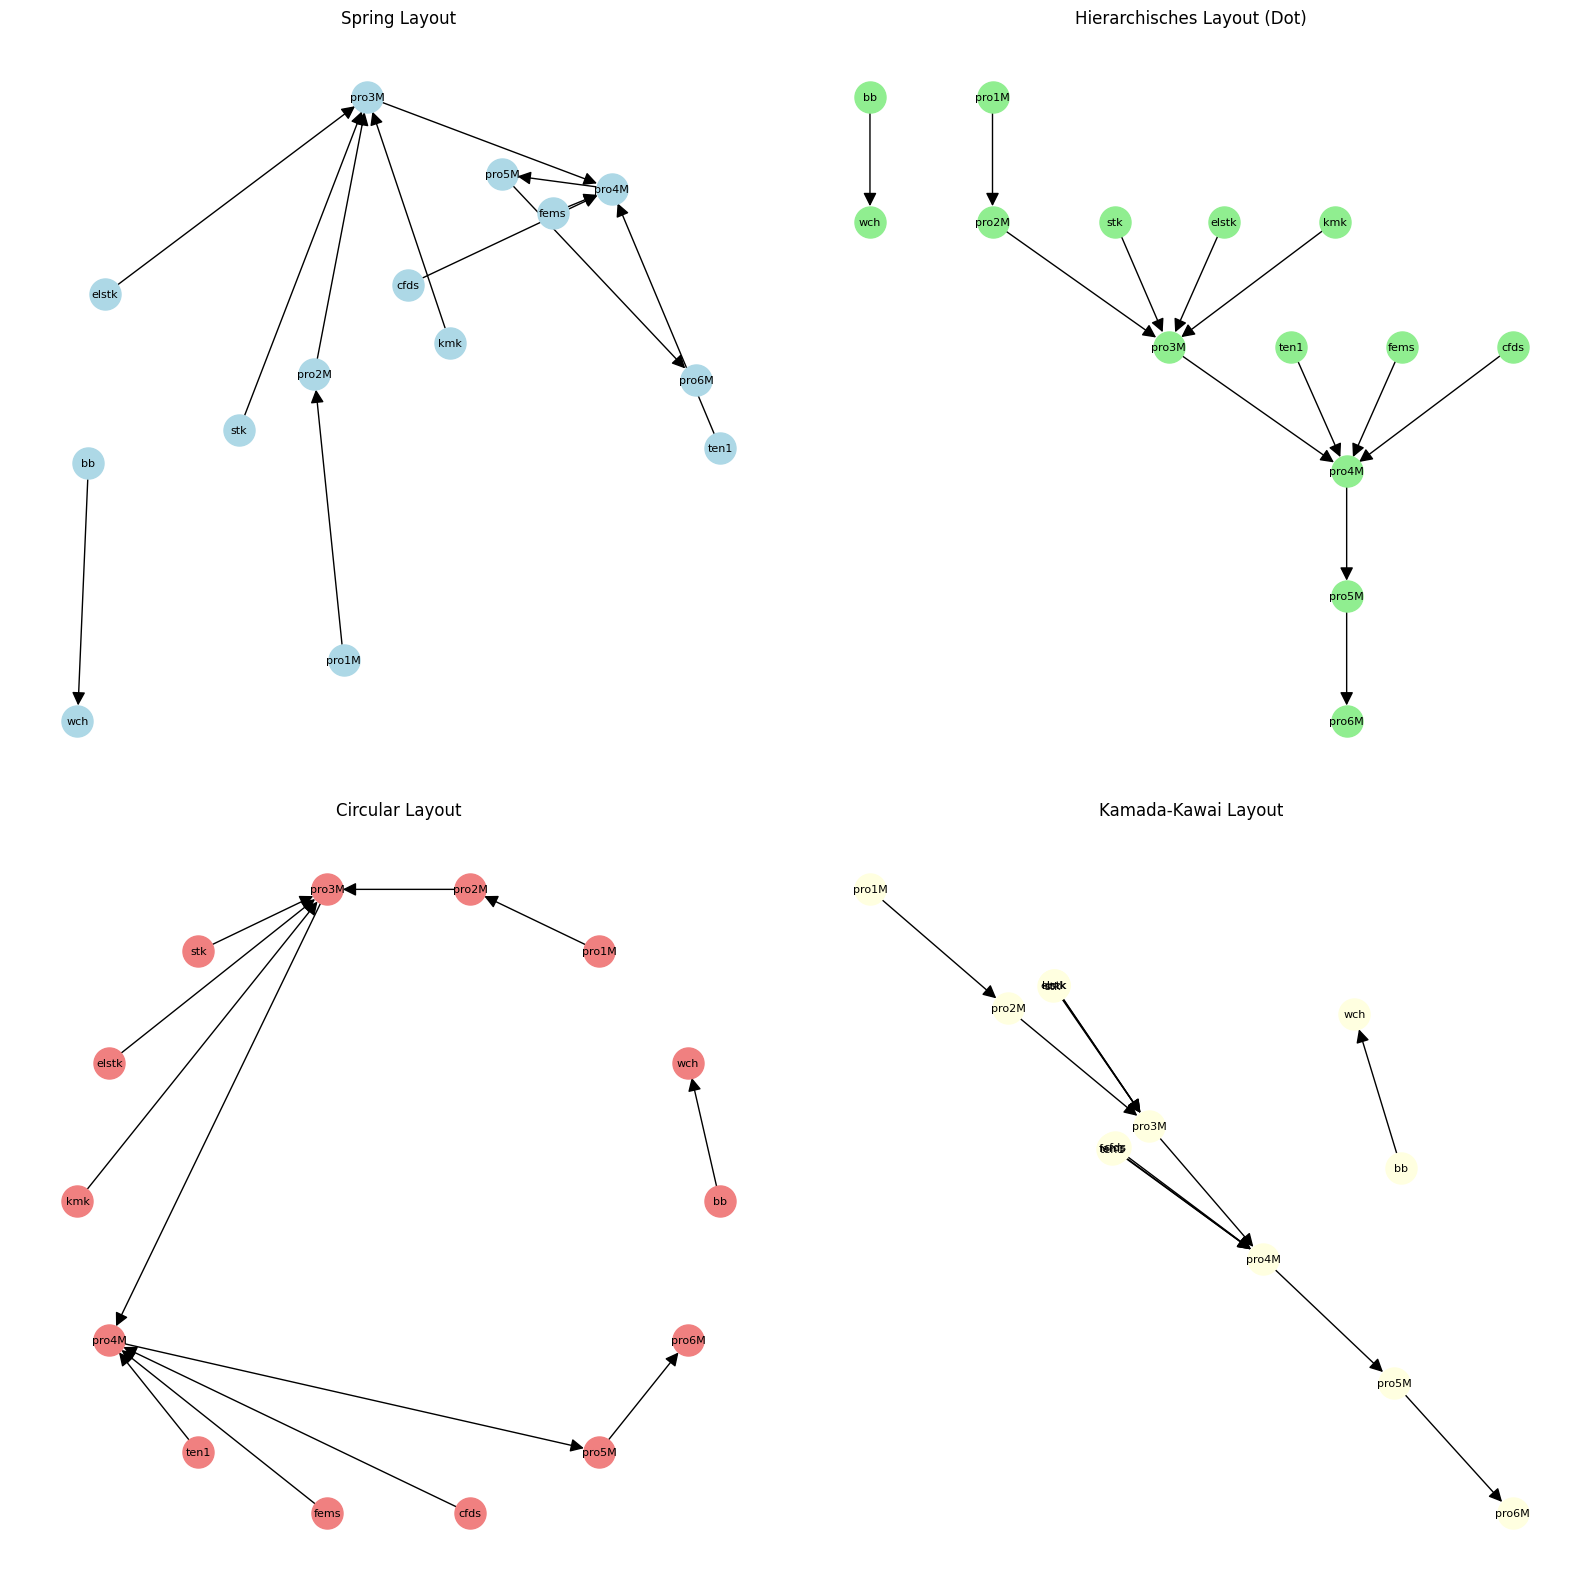

In [16]:
# Visualisierung 1: Grundlegendes Netzwerk-Layout
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# 1. Spring Layout
ax = axes[0, 0]
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue',
        node_size=500, font_size=8, arrows=True, arrowsize=20)
ax.set_title('Spring Layout')

# 2. Hierarchisches Layout (wenn DAG)
ax = axes[0, 1]
if nx.is_directed_acyclic_graph(G):
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
else:
    pos = nx.spring_layout(G)
nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightgreen',
        node_size=500, font_size=8, arrows=True, arrowsize=20)
ax.set_title('Hierarchisches Layout (Dot)')

# 3. Circular Layout
ax = axes[1, 0]
pos = nx.circular_layout(G)
nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightcoral',
        node_size=500, font_size=8, arrows=True, arrowsize=20)
ax.set_title('Circular Layout')

# 4. Kamada-Kawai Layout
ax = axes[1, 1]
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightyellow',
        node_size=500, font_size=8, arrows=True, arrowsize=20)
ax.set_title('Kamada-Kawai Layout')

plt.tight_layout()
plt.show()


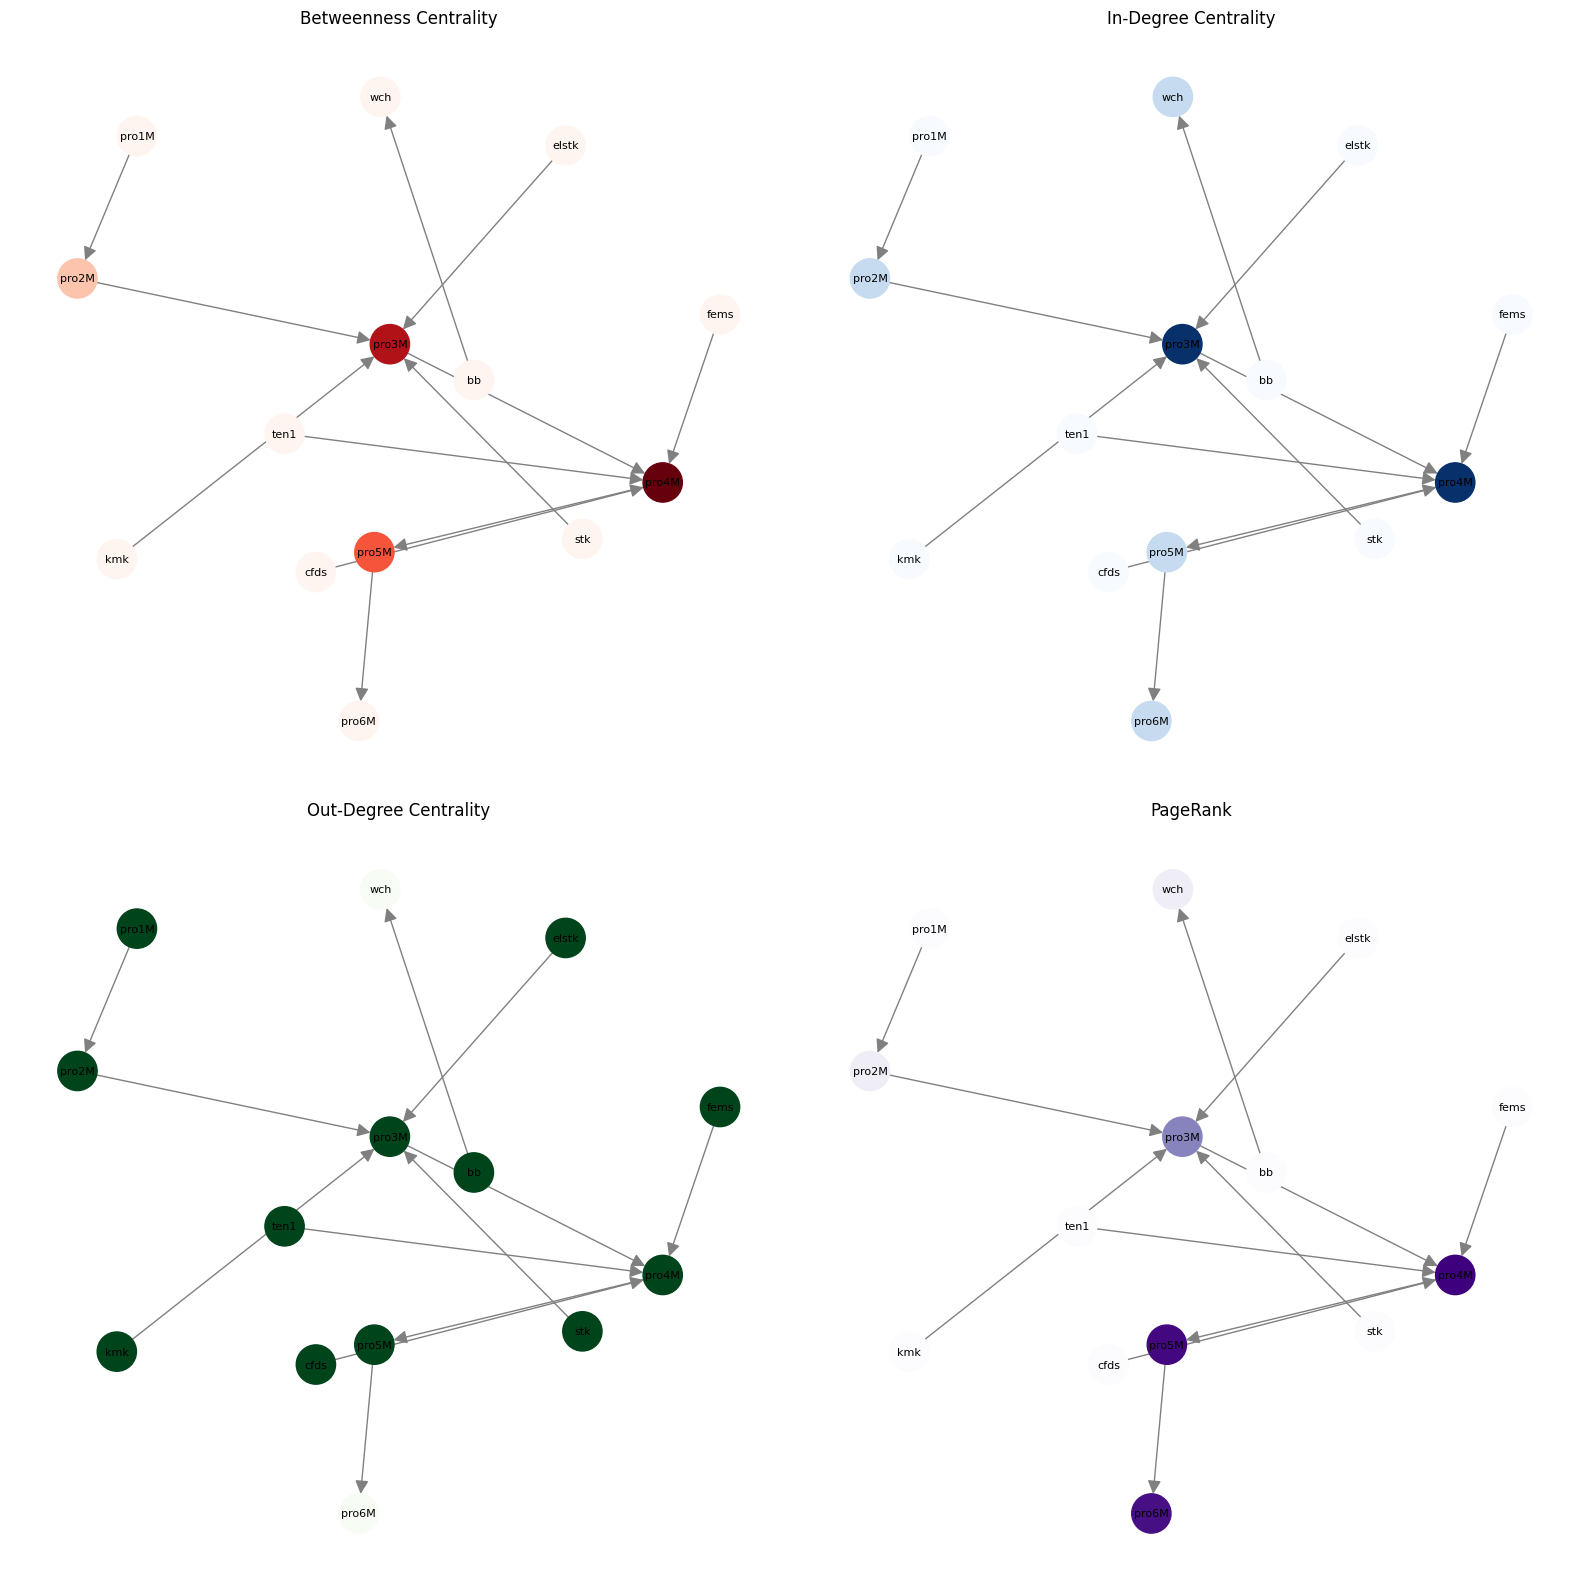

In [17]:
# Visualisierung 2: Netzwerk mit Zentralitätsmaßen
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
pos = nx.spring_layout(G, k=1, iterations=50)

# Betweenness Centrality
ax = axes[0, 0]
betw_values = [nx.betweenness_centrality(G)[n] for n in G.nodes()]
nx.draw(G, pos, ax=ax, with_labels=True, node_color=betw_values,
        node_size=800, font_size=8, arrows=True, arrowsize=20,
        cmap=plt.cm.Reds, edge_color='gray')
ax.set_title('Betweenness Centrality')

# In-Degree Centrality
ax = axes[0, 1]
in_deg_values = [nx.in_degree_centrality(G)[n] for n in G.nodes()]
nx.draw(G, pos, ax=ax, with_labels=True, node_color=in_deg_values,
        node_size=800, font_size=8, arrows=True, arrowsize=20,
        cmap=plt.cm.Blues, edge_color='gray')
ax.set_title('In-Degree Centrality')

# Out-Degree Centrality
ax = axes[1, 0]
out_deg_values = [nx.out_degree_centrality(G)[n] for n in G.nodes()]
nx.draw(G, pos, ax=ax, with_labels=True, node_color=out_deg_values,
        node_size=800, font_size=8, arrows=True, arrowsize=20,
        cmap=plt.cm.Greens, edge_color='gray')
ax.set_title('Out-Degree Centrality')

# PageRank
ax = axes[1, 1]
pagerank_values = [nx.pagerank(G)[n] for n in G.nodes()]
nx.draw(G, pos, ax=ax, with_labels=True, node_color=pagerank_values,
        node_size=800, font_size=8, arrows=True, arrowsize=20,
        cmap=plt.cm.Purples, edge_color='gray')
ax.set_title('PageRank')

plt.tight_layout()
plt.show()


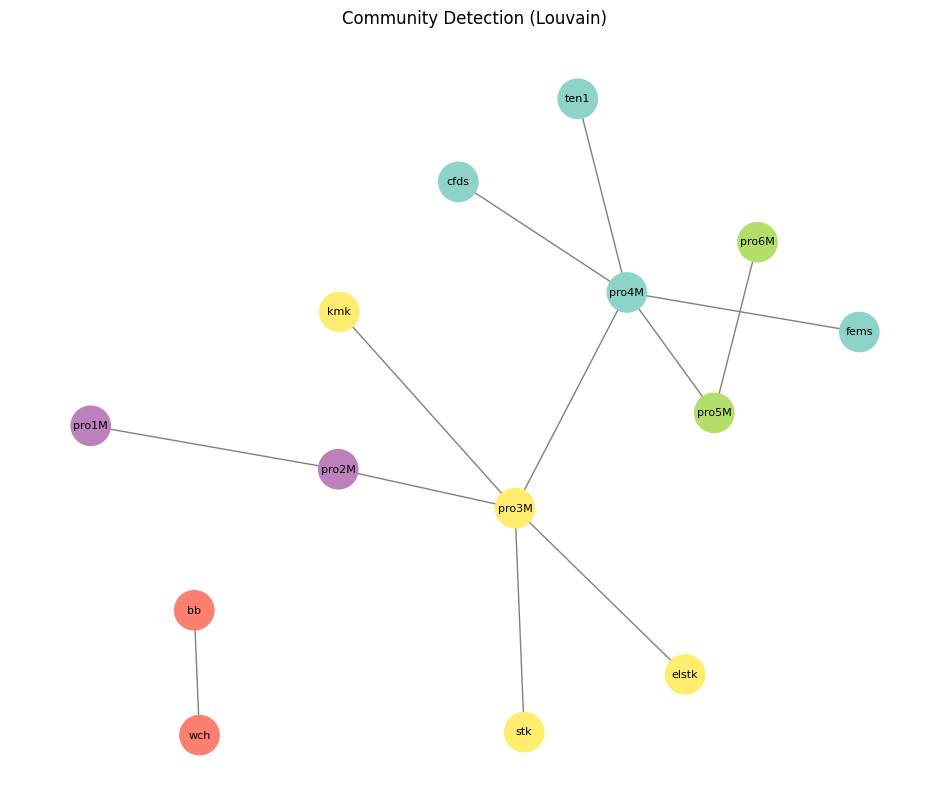

In [18]:
# Visualisierung 3: Communities
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
pos = nx.spring_layout(G_undir, k=1, iterations=50)

# Färbe nach Communities
node_colors = [partition.get(node, 0) for node in G_undir.nodes()]
nx.draw(G_undir, pos, ax=ax, with_labels=True, node_color=node_colors,
        node_size=800, font_size=8, cmap=plt.cm.Set3, edge_color='gray')
ax.set_title('Community Detection (Louvain)')
plt.show()


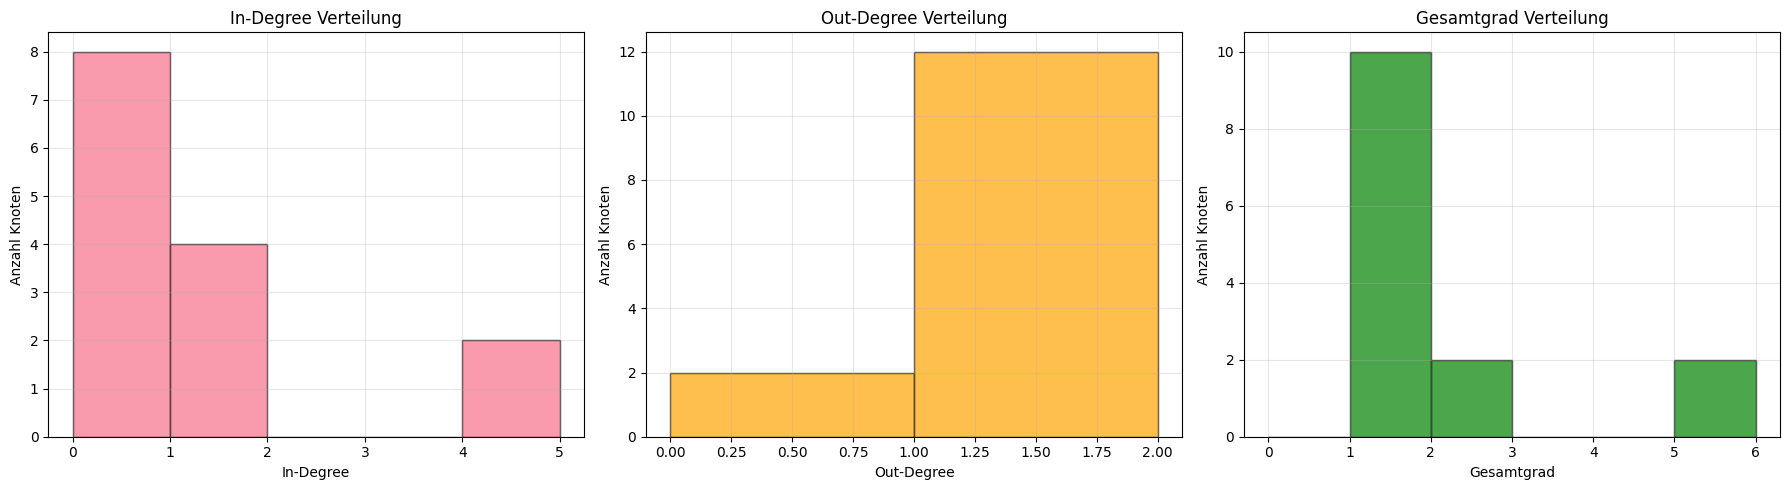

In [19]:
# Visualisierung 4: Grad-Verteilung
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# In-Degree Verteilung
ax = axes[0]
in_degrees = [G.in_degree(n) for n in G.nodes()]
ax.hist(in_degrees, bins=range(max(in_degrees)+2), edgecolor='black', alpha=0.7)
ax.set_xlabel('In-Degree')
ax.set_ylabel('Anzahl Knoten')
ax.set_title('In-Degree Verteilung')
ax.grid(True, alpha=0.3)

# Out-Degree Verteilung
ax = axes[1]
out_degrees = [G.out_degree(n) for n in G.nodes()]
ax.hist(out_degrees, bins=range(max(out_degrees)+2), edgecolor='black', alpha=0.7, color='orange')
ax.set_xlabel('Out-Degree')
ax.set_ylabel('Anzahl Knoten')
ax.set_title('Out-Degree Verteilung')
ax.grid(True, alpha=0.3)

# Gesamtgrad Verteilung
ax = axes[2]
total_degrees = [G.degree(n) for n in G.nodes()]
ax.hist(total_degrees, bins=range(max(total_degrees)+2), edgecolor='black', alpha=0.7, color='green')
ax.set_xlabel('Gesamtgrad')
ax.set_ylabel('Anzahl Knoten')
ax.set_title('Gesamtgrad Verteilung')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 15. Simulationen - Was-wäre-wenn Szenarien


In [20]:
print("=== Was-wäre-wenn Szenarien ===")

# Szenario 1: Was passiert, wenn wir eine neue Verbindung hinzufügen?
print("\nSzenario 1: Neue Verbindung zwischen isolierten Modulen")
isolated_pairs = [(u, v) for u in G.nodes() for v in G.nodes() 
                  if u != v and not G.has_edge(u, v) and G.degree(u) == 0 and G.degree(v) == 0]
if isolated_pairs:
    test_edge = isolated_pairs[0]
    G_test = G.copy()
    G_test.add_edge(test_edge[0], test_edge[1])
    print(f"  Hinzugefügt: {test_edge[0]} -> {test_edge[1]}")
    print(f"  Neue Komponenten: {len(list(nx.weakly_connected_components(G_test)))}")
else:
    print("  Keine isolierten Paare gefunden")

# Szenario 2: Was passiert, wenn wir kritische Module entfernen?
print("\nSzenario 2: Entfernung kritischer Module")
critical_nodes = cent_df.sort_values('Betweenness', ascending=False).head(2).index.tolist()
G_scenario = G.copy()
G_scenario.remove_nodes_from(critical_nodes)
print(f"  Entfernt: {critical_nodes}")
print(f"  Verbleibende Knoten: {G_scenario.number_of_nodes()}")
print(f"  Verbleibende Kanten: {G_scenario.number_of_edges()}")
print(f"  Neue Komponenten: {len(list(nx.weakly_connected_components(G_scenario)))}")

# Szenario 3: Was passiert, wenn wir alle Verbindungen einer Gruppe entfernen?
print("\nSzenario 3: Entfernung aller Verbindungen einer Gruppe")
if len(nodes['Gruppe'].dropna().unique()) > 0:
    test_group = nodes['Gruppe'].dropna().unique()[0]
    group_nodes = [n for n in G.nodes() if G.nodes[n].get('Gruppe') == test_group]
    G_group_removed = G.copy()
    edges_to_remove = [(u, v) for u, v in G_group_removed.edges() 
                       if u in group_nodes or v in group_nodes]
    G_group_removed.remove_edges_from(edges_to_remove)
    print(f"  Gruppe: {test_group}")
    print(f"  Entfernte Kanten: {len(edges_to_remove)}")
    print(f"  Neue Komponenten: {len(list(nx.weakly_connected_components(G_group_removed)))}")


=== Was-wäre-wenn Szenarien ===

Szenario 1: Neue Verbindung zwischen isolierten Modulen
  Keine isolierten Paare gefunden

Szenario 2: Entfernung kritischer Module
  Entfernt: ['pro4M', 'pro3M']
  Verbleibende Knoten: 12
  Verbleibende Kanten: 3
  Neue Komponenten: 9

Szenario 3: Entfernung aller Verbindungen einer Gruppe
  Gruppe: Grundlagen: Mathematik 1
  Entfernte Kanten: 0
  Neue Komponenten: 2


## 16. Erweiterte Analysen - Bipartite Eigenschaften und mehr


In [21]:
print("=== Erweiterte Strukturanalysen ===")

# Prüfe auf bipartite Eigenschaften (Quellen vs. Senken)
sources = [n for n in G.nodes() if G.in_degree(n) == 0]
sinks = [n for n in G.nodes() if G.out_degree(n) == 0]
middle = [n for n in G.nodes() if n not in sources and n not in sinks]

print(f"Quellen: {len(sources)} ({sources})")
print(f"Senken: {len(sinks)} ({sinks})")
print(f"Mittlere Knoten: {len(middle)}")

# Analysiere Pfade von Quellen zu Senken
source_to_sink_paths = []
for source in sources:
    for sink in sinks:
        if nx.has_path(G, source, sink):
            path = nx.shortest_path(G, source, sink)
            source_to_sink_paths.append({
                'Source': source,
                'Sink': sink,
                'Length': len(path) - 1,
                'Path': path
            })

if source_to_sink_paths:
    path_df = pd.DataFrame(source_to_sink_paths)
    print(f"\nAnzahl Quellen-zu-Senken-Pfade: {len(path_df)}")
    print(f"Durchschnittliche Länge: {path_df['Length'].mean():.2f}")
    print(f"Längster Pfad: {path_df['Length'].max()} Schritte")
    
    # Häufigste Quellen und Senken
    print("\nHäufigste Quellen (in Pfaden):")
    print(path_df['Source'].value_counts().head())
    print("\nHäufigste Senken (in Pfaden):")
    print(path_df['Sink'].value_counts().head())

# Analysiere Knoten, die viele Pfade durchlaufen
node_path_counts = defaultdict(int)
for path_info in source_to_sink_paths:
    for node in path_info['Path'][1:-1]:  # Ohne Start und Ende
        node_path_counts[node] += 1

if node_path_counts:
    print("\nKnoten, die in den meisten Pfaden vorkommen:")
    sorted_nodes = sorted(node_path_counts.items(), key=lambda x: x[1], reverse=True)
    for node, count in sorted_nodes[:5]:
        print(f"  {node}: {count} Pfade")


=== Erweiterte Strukturanalysen ===
Quellen: 8 (['bb', 'pro1M', 'stk', 'elstk', 'kmk', 'ten1', 'fems', 'cfds'])
Senken: 2 (['wch', 'pro6M'])
Mittlere Knoten: 4

Anzahl Quellen-zu-Senken-Pfade: 8
Durchschnittliche Länge: 3.38
Längster Pfad: 5 Schritte

Häufigste Quellen (in Pfaden):
Source
bb       1
pro1M    1
stk      1
elstk    1
kmk      1
Name: count, dtype: int64

Häufigste Senken (in Pfaden):
Sink
pro6M    7
wch      1
Name: count, dtype: int64

Knoten, die in den meisten Pfaden vorkommen:
  pro4M: 7 Pfade
  pro5M: 7 Pfade
  pro3M: 4 Pfade
  pro2M: 1 Pfade


### Interpretation der erweiterten Strukturanalysen

**Quellen-zu-Senken-Pfade:**
- **8 Pfade** führen von Quellen zu Senken
- **Durchschnittliche Länge: 3.38 Schritte** - Studenten müssen durchschnittlich 3-4 Module durchlaufen, um von einem Startmodul zur Bachelor Thesis zu gelangen
- **pro6M** (Bachelor Thesis) ist das häufigste Ziel (7 von 8 Pfaden enden dort)

**Kritische Knoten in Pfaden:**
- **pro4M** und **pro5M** kommen in 7 von 8 Pfaden vor - sie sind fast unvermeidbar
- **pro3M** kommt in 4 Pfaden vor
- Diese Module sind **Pflichtmodule** im wahren Sinne - fast alle Studienwege führen durch sie

**Bedeutung für die Studienplanung:**
- Studenten haben **wenig Flexibilität** in der Projektsequenz - fast alle Wege führen durch pro3M, pro4M, pro5M zu pro6M
- **Empfehlung:** Diese Module sollten besonders gut unterstützt werden, da sie für fast alle Studenten obligatorisch sind
- Die geringe Anzahl alternativer Pfade zeigt eine **lineare Studienstruktur** mit wenig Wahlmöglichkeiten

**Praktische Konsequenz:** Studenten, die in pro3M, pro4M oder pro5M scheitern, haben kaum Ausweichmöglichkeiten. Dies erhöht den Druck auf diese Module und sollte bei der Prüfungsplanung berücksichtigt werden.


## 17. Korrelationsanalyse - Zusammenhänge zwischen Metriken


=== Korrelationsanalyse zwischen Metriken ===

Korrelationsmatrix (Top-Korrelationen):
  OutDegree <-> OutDegree_abs: 1.000
  InDegree <-> InDegree_abs: 1.000
  Katz <-> InDegree_abs: 0.997
  InDegree <-> Katz: 0.997
  PageRank <-> Erreichbar_von: 0.991
  InDegree <-> TotalDegree: 0.968
  InDegree_abs <-> TotalDegree: 0.968
  Katz <-> TotalDegree: 0.966
  Betweenness <-> TotalDegree: 0.963
  Closeness <-> PageRank: 0.958


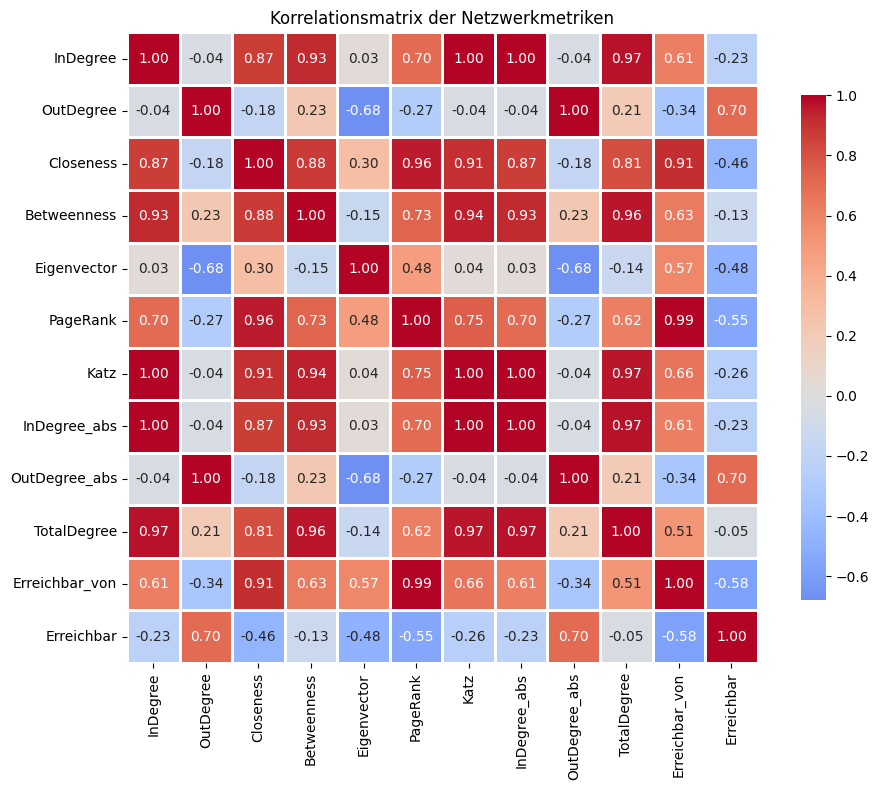

In [23]:
print("=== Korrelationsanalyse zwischen Metriken ===")

# Erstelle umfassende Metrik-Tabelle
metrics_df = cent_df.copy()
metrics_df['InDegree_abs'] = [G.in_degree(n) for n in G.nodes()]
metrics_df['OutDegree_abs'] = [G.out_degree(n) for n in G.nodes()]
metrics_df['TotalDegree'] = [G.degree(n) for n in G.nodes()]

# Füge Erreichbarkeits-Metriken hinzu
metrics_df['Erreichbar_von'] = metrics_df.index.map(reachable_from_counts)
metrics_df['Erreichbar'] = metrics_df.index.map(reachable_counts)

# Korrelationsmatrix
corr_matrix = metrics_df.corr()
print("\nKorrelationsmatrix (Top-Korrelationen):")
# Zeige nur hohe Korrelationen
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
for col1, col2, corr in high_corr[:10]:
    print(f"  {col1} <-> {col2}: {corr:.3f}")

# Visualisiere Korrelationsmatrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .8}, ax=ax)
ax.set_title('Korrelationsmatrix der Netzwerkmetriken')
plt.tight_layout()
plt.show()


### Interpretation der Korrelationsanalyse

**Starke Korrelationen (>0.95):**
- **PageRank ↔ Erreichbar_von (0.991):** Module, die von vielen anderen erreicht werden können, haben hohen PageRank. Dies bestätigt, dass pro6M (Bachelor Thesis) das zentrale Ziel ist.
- **InDegree ↔ Katz (0.997):** Module mit vielen Voraussetzungen haben hohe Katz-Zentralität. Dies zeigt, dass pro3M und pro4M fundamentale Bausteine sind.
- **InDegree ↔ TotalDegree (0.968):** Die meisten Verbindungen sind eingehend - das Netzwerk ist stark hierarchisch strukturiert.

**Bedeutung:**
- Die hohen Korrelationen zeigen, dass verschiedene Zentralitätsmaße ähnliche Module identifizieren
- **pro3M, pro4M, pro5M** erscheinen in allen Metriken als wichtig - dies bestätigt ihre kritische Rolle
- Die Konsistenz der Metriken zeigt, dass die Identifikation kritischer Module robust ist

**Praktische Anwendung:** Da verschiedene Metriken zu ähnlichen Ergebnissen führen, können wir sicher sein, dass pro3M und pro4M tatsächlich die kritischsten Module sind. Die Studienplanung sollte diese Erkenntnis nutzen.


## 18. Netzwerk-Vergleich - Vergleich mit zufälligen Netzwerken


=== Vergleich mit zufälligen Netzwerken ===

Vergleich: Tatsächlich vs. Zufällig (Durchschnitt über 10 Zufallsnetzwerke)
                 Tatsächlich  Zufällig (Ø)  Differenz
density               0.0659        0.0659     0.0000
clustering            0.0000        0.0386    -0.0386
avg_path_length       1.7308        1.9517    -0.2209
transitivity          0.0000        0.0986    -0.0986


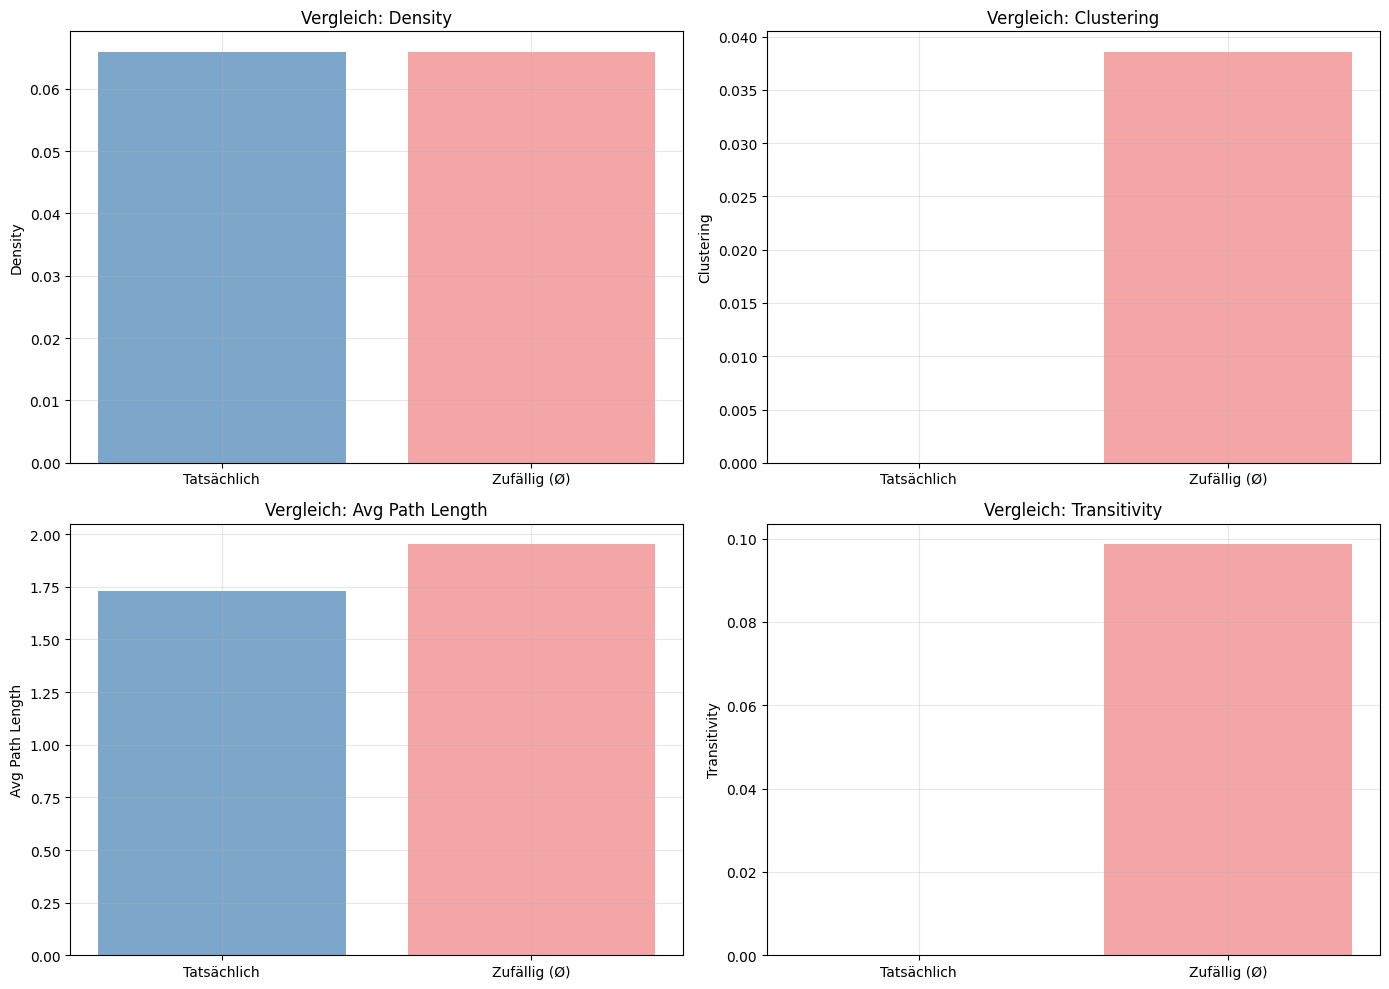

In [24]:
print("=== Vergleich mit zufälligen Netzwerken ===")

# Erstelle zufälliges Netzwerk mit gleicher Anzahl Knoten und Kanten
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()

# Erstelle mehrere zufällige Netzwerke und vergleiche
random_metrics = {
    'density': [],
    'clustering': [],
    'avg_path_length': [],
    'transitivity': []
}

for i in range(10):
    G_random = nx.gnm_random_graph(n_nodes, n_edges, directed=True)
    G_random_undir = G_random.to_undirected()
    
    random_metrics['density'].append(nx.density(G_random))
    random_metrics['clustering'].append(nx.average_clustering(G_random_undir))
    
    # Durchschnittliche Pfadlänge
    path_lengths = []
    for source in G_random.nodes():
        for target in G_random.nodes():
            if source != target and nx.has_path(G_random, source, target):
                path_lengths.append(nx.shortest_path_length(G_random, source, target))
    random_metrics['avg_path_length'].append(np.mean(path_lengths) if path_lengths else 0)
    random_metrics['transitivity'].append(nx.transitivity(G_random_undir))

# Berechne Durchschnitte
random_avg = {k: np.mean(v) for k, v in random_metrics.items()}

# Vergleich mit tatsächlichem Netzwerk
actual_metrics = {
    'density': nx.density(G),
    'clustering': nx.average_clustering(G_undir),
    'avg_path_length': np.mean(path_lengths) if path_lengths else 0,
    'transitivity': nx.transitivity(G_undir)
}

print("\nVergleich: Tatsächlich vs. Zufällig (Durchschnitt über 10 Zufallsnetzwerke)")
comparison_df = pd.DataFrame({
    'Tatsächlich': actual_metrics,
    'Zufällig (Ø)': random_avg
})
comparison_df['Differenz'] = comparison_df['Tatsächlich'] - comparison_df['Zufällig (Ø)']
print(comparison_df.round(4))

# Visualisierung
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(['density', 'clustering', 'avg_path_length', 'transitivity']):
    ax = axes[idx]
    ax.bar(['Tatsächlich', 'Zufällig (Ø)'], 
           [actual_metrics[metric], random_avg[metric]],
           color=['steelblue', 'lightcoral'], alpha=0.7)
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'Vergleich: {metric.replace("_", " ").title()}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Interpretation des Vergleichs mit zufälligen Netzwerken

**Dichte:** Identisch (0.0659) - dies ist erwartbar, da zufällige Netzwerke mit gleicher Anzahl Knoten und Kanten die gleiche Dichte haben.

**Clustering (-0.0386):** Das tatsächliche Netzwerk hat **kein Clustering**, während zufällige Netzwerke etwas Clustering zeigen. Dies bestätigt die lineare, hierarchische Struktur ohne Dreiecke.

**Durchschnittliche Pfadlänge (-0.22):** Das tatsächliche Netzwerk hat **kürzere Pfade** als zufällige Netzwerke. Dies ist vorteilhaft - Studenten müssen weniger "Umwege" machen.

**Transitivität (-0.0986):** Das tatsächliche Netzwerk hat keine Transitivität, während zufällige Netzwerke etwas zeigen. Dies bestätigt die DAG-Struktur.

**Gesamtinterpretation:**
- Das Curriculum ist **effizienter strukturiert** als ein zufälliges Netzwerk
- Die kürzeren Pfade bedeuten, dass Studenten schneller zu ihren Zielen kommen können
- Die fehlende Clustering zeigt eine klare, lineare Struktur ohne redundante Verbindungen
- **Bewertung:** Die Netzwerkstruktur ist gut optimiert für einen Studienplan - sie ist effizient und klar strukturiert
